In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
data_dir = 'data/640_high_poll_dataset/captures/'

In [3]:
def get_picture(_id, _dir=data_dir):
    rgb = cv2.imread(os.path.join(_dir, f'{_id}_scene.png'))
    seg = cv2.imread(os.path.join(_dir, f'{_id}_seg.png'))
    return (rgb, seg)

In [189]:
rgb, seg = get_picture('999')

In [190]:
def imshow(image):
    plt.imshow(image[:,:,::-1])

In [191]:
focal_length = rgb.shape[1] / 2

In [192]:
from lu_vp_detect import VPDetection

In [193]:
length_thresh = 1
pp = None

In [194]:
vpd = VPDetection(length_thresh, pp, focal_length)

In [195]:
vps = vpd.find_vps(rgb)

In [196]:
x = vpd.create_debug_VP_image()

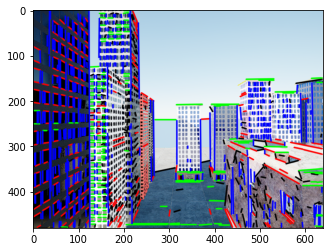

In [197]:
imshow(x)

In [198]:
background_id = 0
floor_id = 39

In [199]:
cv2.imwrite('test.png',x)

True

In [200]:
lines = np.round(vpd._VPDetection__lines).astype('int')
clusters = vpd._VPDetection__clusters

In [201]:
lines.shape

(1135, 4)

In [202]:
temp_image = np.zeros(rgb.shape)

In [203]:
old_img = vpd._VPDetection__img.copy()
vpd._VPDetection__img = temp_image.copy()

In [204]:
img = vpd.create_debug_VP_image()

In [205]:
ids = np.zeros((256,256,256))
ids = np.load('ids.npy')

In [206]:
id_image = ids[seg[:,:,0], seg[:,:,1], seg[:,:,2]].copy()

In [207]:
with open('rgb-ids.txt') as f:
    for line in f.readlines():
        s = line.split()
        ids[int(s[1]), int(s[2]), int(s[3])] = int(s[0])

In [208]:
ids = ids.astype('int')

In [227]:
id_image[:,190]

array([120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 116., 116., 116., 116., 116., 11

In [232]:
vps_2D

array([[   325.00204,    242.77269],
       [-20292.531  ,    494.25214],
       [  -120.77072, -35896.57   ]], dtype=float32)

In [231]:
lines

array([[165, 403, 166, 392],
       [165, 373, 166, 361],
       [165, 388, 166, 376],
       ...,
       [576, 182, 552, 182],
       [282, 433, 296, 433],
       [ 39,  19,  39,   1]])

In [209]:
line_ids = np.ones((lines.shape[0], 2),dtype=int)

In [210]:
line_ids *= -1
line_ids

array([[-1, -1],
       [-1, -1],
       [-1, -1],
       ...,
       [-1, -1],
       [-1, -1],
       [-1, -1]])

In [211]:
line_ids[:,0] = id_image[lines[:,1], lines[:,0]]
line_ids[:,1] = id_image[lines[:,3], lines[:,2]]
line_ids

array([[116, 116],
       [116, 116],
       [116, 116],
       ...,
       [ 53,  53],
       [ 39,  39],
       [111, 111]])

In [212]:
vps_2D = vpd.vps_2D

In [234]:
freq = np.zeros((300, 6), dtype=int)
freq1 = np.zeros((300, 3), dtype=int)
i = 0
for i, cluster in enumerate(clusters):
    lines_ids_c = line_ids[cluster]
    eq_mask = lines_ids_c[:,0] == lines_ids_c[:,1]
    lines_ids_c = lines_ids_c[eq_mask]
    lines_c = lines[cluster][eq_mask]
    seg_mask = (lines_c[:,0] <= vps_2D[0][0]) 
    lines_ids_c1 = lines_ids_c[seg_mask]
    lines_ids_c2 = lines_ids_c[seg_mask == False]
    un1, cnts1 = np.unique(lines_ids_c1[:,0], return_counts=True)
    un2, cnts2 = np.unique(lines_ids_c2[:,0], return_counts=True)
    un, cnt = np.unique(lines_ids_c[:,0], return_counts=True)
    freq[un1, 2*i] += cnts1
    freq[un2, 2*i + 1] += cnts2
    freq1[un, i] += cnt
    # print(lines_c)

In [235]:
freq_min = freq1.argmin(axis=1)

In [236]:
faces = freq_min.copy()

In [237]:
faces = freq_min.copy()
faces[(faces == 1) & (freq[:,0] < freq[:,1])] = 3
# Assign floor id
faces[39] = 2

faces += 1
faces[0] = 0
faces[freq1.max(axis=1) <= 5] = 0

In [238]:
face_image = faces[id_image.astype('int')]

True

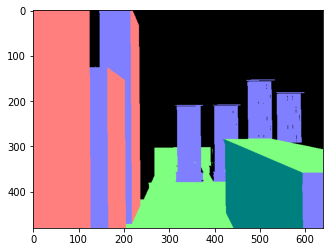

In [239]:
normals_map = np.array([[0,0,0],[0,0,1],[1,0,0], [0,1,0],[-1,0,0]],dtype=np.float32)
color = ((normals_map * 0.5 + 0.5) * 255).astype('int')
color[0] = 0
color = color[:,::-1]
imshow(color[face_image])
cv2.imwrite('test.png', color[face_image])

In [158]:
seg = (face_image > 0) * 255

In [397]:
seg = np.repeat(seg[:,:, np.newaxis], repeats=3, axis=2)

In [230]:
freq[116]

array([ 3, 19,  0,  0,  6, 15])

In [366]:
vpd.vps_2D

array([[   375.30566,    245.50903],
       [ -1532.0769 ,    245.50903],
       [   320.     , -18347.654  ]], dtype=float32)

array([ True, False, False, ..., False,  True, False])

array([[161, 153],
       [158, 326],
       [158, 371],
       ...,
       [316, 399],
       [ 68,  31],
       [313, 303]])

In [ ]:
correct = [59,56,83